## [Grant et al.] Heirarchical Quantum Classifiers

Heirarchical Quantum Classifiers[1] presents two different ansatz inspired by tensor networks. Namely, Multi-scale entaglement renormalization ansatz (MERA) and Tree Tensor Network (TTN). Grant et al. train the Parameterize Quantum Circuits (PQCs) from these ansatz for binary classification tasks based on the IRIS dataset.

We demonstrate the work presented in [1], by classifying the classes in IRIS and compare their performance. We also chose to use only $ry$ (i.e real) rotations in the ansatz. All the other details will be the same as [1]. 

We will use cirq and tensorflow-quantum.

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import keras as kr
import cirq
import sympy
import numpy as np
import os, csv

# visualization tools
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

2023-08-16 20:15:42.936824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-16 20:15:42.936858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-16 20:15:48.706720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-16 20:15:48.706757: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-16 20:15:48.706808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-alberto-40qbraid-2ecom): /proc/driver/nvidia/version does not exist
2023-08-16 20:15:48.707082: I tensorflow/core/

In [2]:
!export IRIS_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" && curl $IRIS_URL > iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551    0  4551    0     0  14493      0 --:--:-- --:--:-- --:--:-- 14539


# Classical  part

In [3]:
iris_data = pd.read_csv("./iris.csv")
iris_data.head()

5.1  3.5  1.4  0.2  Iris-setosa
0  4.9  3.0  1.4  0.2  Iris-setosa
1  4.7  3.2  1.3  0.2  Iris-setosa
2  4.6  3.1  1.5  0.2  Iris-setosa
3  5.0  3.6  1.4  0.2  Iris-setosa
4  5.4  3.9  1.7  0.4  Iris-setosa

In [4]:
all_inputs = iris_data.iloc[:, 0:4].values
all_types = iris_data.iloc[:, 4].values

In [5]:
print(all_inputs[56], " - ", all_types[57])

[4.9 2.4 3.3 1. ]  -  Iris-versicolor


In [6]:
outputs_vals, outputs_ints = np.unique(all_types, return_inverse=True)
outputs_cats = tf.keras.utils.to_categorical(outputs_ints)
outputs_vals[0], outputs_ints[0], outputs_cats[0]

('Iris-setosa', 0, array([1., 0., 0.], dtype=float32))

In [7]:
c_x_train, c_x_test, c_y_train, c_y_test = train_test_split(
    all_inputs, outputs_cats, test_size=0.1, random_state=seed
)

In [8]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(2, input_shape=(4,)))
# model.add(kr.layers.Activation("sigmoid"))
model.add(kr.layers.Dense(3))
model.add(kr.layers.Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/100
134/134 [==============================] - 0s 765us/step - loss: 1.6271 - accuracy: 0.0075
Epoch 2/100
134/134 [==============================] - 0s 762us/step - loss: 1.2109 - accuracy: 0.2836
Epoch 3/100
134/134 [==============================] - 0s 732us/step - loss: 1.0243 - accuracy: 0.3582
Epoch 4/100
134/134 [==============================] - 0s 765us/step - loss: 0.8896 - accuracy: 0.3657
Epoch 5/100
134/134 [==============================] - 0s 715us/step - loss: 0.7813 - accuracy: 0.4179
Epoch 6/100
134/134 [==============================] - 0s 733us/step - loss: 0.6971 - accuracy: 0.6791
Epoch 7/100
134/134 [==============================] - 0s 783us/step - loss: 0.6290 - accuracy: 0.7537
Epoch 8/100
134/134 [==============================] - 0s 715us/step - loss: 0.5746 - accuracy: 0.8507
Epoch 9/100
134/134 [==============================] - 0s 733us/step - loss: 0.5286 - accuracy: 0.8284
Epoch 10/100
134/134 [==============================] - 0s 730us/step - l

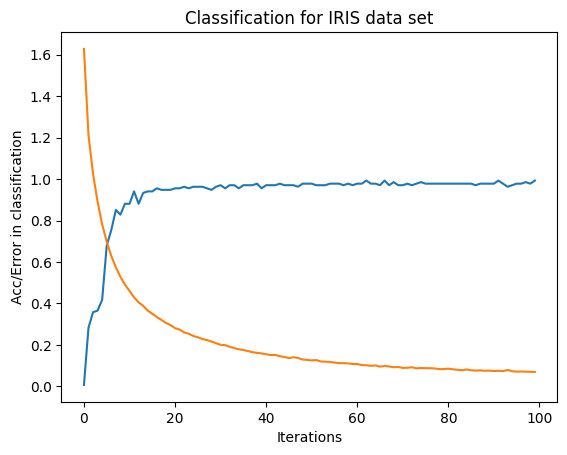

Final accuracy value: 0.9925373196601868
Final loss value: 0.0699608325958252


In [10]:
history = model.fit(c_x_train, c_y_train, epochs=100, batch_size=1, verbose=1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Classification for IRIS data set")
plt.xlabel("Iterations")
plt.ylabel("Acc/Error in classification")
plt.show()
print("Final accuracy value:", history.history["accuracy"][-1])
print("Final loss value:", history.history["loss"][-1])

In [11]:
c_pred = model.predict(c_x_test)
(1 - np.mean(np.abs(c_pred - c_y_test))) * 1

0.9195849522948265

## Data Encoding

### IRIS data set encoding
We standardize the data and make this a binary classification problem.

1. First we will fetch the IRIS dataset
2. Select the datagrams with labels 0, 1 or 2, and set the label as [-1,-1],[-1,1],[1,1] respectively.


### Standardize the data

In [12]:
class IrisData:
    def __init__(self):
        return

    def _get_binary_dataset(self):
        with open("./iris.csv") as csv_file:
            reader = csv.reader(csv_file, delimiter=",")
            rows = list(reader)
            rows.pop()
            data = [row for row in rows if row[4]]
            for datum in data:
                if datum[4] == "Iris-versicolor":
                    datum[4] = 0
                elif datum[4] == "Iris-setosa":
                    datum[4] = 1
                else:
                    datum[4] = 2
            data = np.array(data, dtype=np.float32)
            labels = data[:, 4]
            data = data[:, :4]
            data = data.reshape(150, 4, 1)
            return data, labels

    def get_binary_test_train_split(self):
        data, labels = self._get_binary_dataset()
        _data = []

        qubits = cirq.GridQubit.rect(1, 4)
        for idx in range(data.shape[0]):
            datapoint = data[idx]
            _circuit = cirq.Circuit()

            _circuit.append(cirq.ry(datapoint[0][0])(qubits[0]))
            _circuit.append(cirq.ry(datapoint[1][0])(qubits[1]))
            _circuit.append(cirq.ry(datapoint[2][0])(qubits[2]))
            _circuit.append(cirq.ry(datapoint[3][0])(qubits[3]))
            _data.append(_circuit)
        enc_labels = []
        for i in labels:
            if i == 0:
                enc_labels.append([1, 0, 0])
            elif i == 1:
                enc_labels.append([0, 1, 0])
            elif i == 2:
                enc_labels.append([0, 0, 1])
        X_train, X_test, y_train, y_test = train_test_split(
            _data, np.asarray(enc_labels), test_size=0.1, random_state=seed
        )
        # display(SVGCircuit(X_train[0]))
        X_train, X_test = tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test)
        return X_train, X_test, y_train, y_test

    def get_binary_test_train_split_img(self):
        data, labels = self._get_binary_dataset()
        _data = []

        qubits = cirq.GridQubit.rect(1, 4)
        for idx in range(data.shape[0]):
            datapoint = data[idx]
            _circuit = cirq.Circuit()

            _circuit.append(cirq.ry(datapoint[0][0])(qubits[0]))
            _circuit.append(cirq.ry(datapoint[1][0])(qubits[1]))
            _circuit.append(cirq.ry(datapoint[2][0])(qubits[2]))
            _circuit.append(cirq.ry(datapoint[3][0])(qubits[3]))

            # _circuit.append(encode_classical_datapoint(np.array(datapoint[i][::-1]), [qubits[i]]))
            _data.append(_circuit)
        enc_labels = []
        for i in labels:
            if i == 0:
                enc_labels.append([1, 0, 0])
            elif i == 1:
                enc_labels.append([0, 1, 0])
            elif i == 2:
                enc_labels.append([0, 0, 1])
        X_train, X_test, y_train, y_test = train_test_split(
            _data, np.asarray(enc_labels), test_size=0.1, random_state=seed, shuffle=True
        )
        display(SVGCircuit(X_train[0]))
        X_train, X_test = tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test)
        return X_train, X_test, y_train, y_test

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


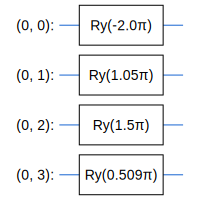

(135,) (15,) (135, 3) (15, 3)


In [13]:
iris_data = IrisData()
X_train, X_test, y_train, y_test = iris_data.get_binary_test_train_split_img()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Model Definitions

In [14]:
class TTNBinaryClassificationModel:
    def __init__(self):
        return

    def _ttn_model_iris(self, qubits):
        symbols, circuit = sympy.symbols("x0:19"), cirq.Circuit()
        circuit.append(cirq.Y(qubits[0]) ** (symbols[0]))
        circuit.append(cirq.CNOT(qubits[0], qubits[1]))
        circuit.append(cirq.ry(symbols[1])(qubits[1]))

        circuit.append(cirq.ry(symbols[2])(qubits[2]))
        circuit.append(cirq.CNOT(qubits[2], qubits[3]))
        circuit.append(cirq.ry(symbols[3])(qubits[3]))

        circuit.append(cirq.ry(symbols[4])(qubits[0]))
        circuit.append(cirq.CNOT(qubits[0], qubits[2]))
        circuit.append(cirq.ry(symbols[5])(qubits[2]))

        return circuit, symbols

    @tf.function
    def _custom_accuracy(self, y_true, y_pred):
        y_pred = tf.sign(y_pred)

        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, tf.sign(y_pred)))

    def _iris_model_compile(self):
        # declare qubits and readout operators
        iris_data = IrisData()
        (
            self.iris_X_train,
            self.iris_X_test,
            self.iris_y_train,
            self.iris_y_test,
        ) = iris_data.get_binary_test_train_split()

        cluster_state_bits = cirq.GridQubit.rect(1, 4)
        readout_operators = [
            cirq.Z(cluster_state_bits[1]),
            cirq.Z(cluster_state_bits[2]),
            cirq.Z(cluster_state_bits[3]),
        ]

        iris_ttn_model, symbols = self._ttn_model_iris(cluster_state_bits)

        iris_model = tf.keras.Sequential(
            [
                # The input is the data-circuit, encoded as a tf.string
                tf.keras.layers.Input(shape=(), dtype=tf.string),
                # The PQC layer returns the expected value of the readout gate, range [-1,1].
                tfq.layers.PQC(iris_ttn_model, readout_operators),
                # tf.keras.layers.Reshape((1,3)),
                # tf.keras.layers.LSTM(units=1),
                tf.keras.layers.Dense(units=3),
                tf.keras.layers.Activation("softmax"),
            ]
        )

        print(iris_model.summary())
        iris_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        tf.keras.utils.plot_model(iris_model, show_shapes=True, dpi=70)

        self.iris_model = iris_model

    def iris_model_fit(self):
        self._iris_model_compile()
        history = self.iris_model.fit(
            x=self.iris_X_train, y=self.iris_y_train, batch_size=1, epochs=100, verbose=1
        )
        # print(history)
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["loss"])
        plt.title("Classification for IRIS data set")
        plt.xlabel("Iterations")
        plt.ylabel("Acc/Error in classification")
        plt.show()
        print("Final accuracy value:", history.history["accuracy"][-1])
        print("Final loss value:", history.history["loss"][-1])

    def iris_model_accuracy(self):
        predicted = self.iris_model.predict(self.iris_X_test)
        iris_y_test = self.iris_y_test
        return (1 - np.mean(np.abs(predicted - iris_y_test))) * 100

In [15]:
ttn_binary_classification_model = TTNBinaryClassificationModel()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


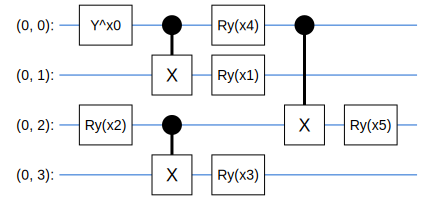

In [16]:
SVGCircuit(ttn_binary_classification_model._ttn_model_iris(cirq.GridQubit.rect(1, 4))[0])

### Training

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 3)                 6         
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
None
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100
135/135 [==============================] - 1s 2ms/step - loss: 0.9946 - accuracy: 0.5037
Epoch 2/100
135/135 [=========================

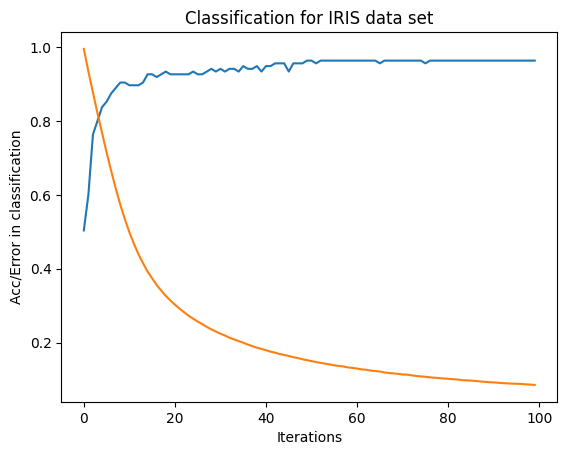

Final accuracy value: 0.9629629850387573
Final loss value: 0.08585051447153091


In [17]:
ttn_binary_classification_model.iris_model_fit()

In [18]:
ttn_binary_classification_model.iris_model_accuracy()

95.64185839128994

### References:

1. Grant, E., Benedetti, M., Cao, S., Hallam, A., Lockhart, J., Stojevic, V., Green, A.G. and Severini, S., 2018. Hierarchical quantum classifiers. npj Quantum Information, 4(1), pp.1-8.

2. Fisher, R. A. The use of multiple measurements in taxonomic problems.Ann. Hum.Genet.7, 179–188 (1936)

3. Vartiainen, J.J., Möttönen, M. and Salomaa, M.M., 2004. Efficient decomposition of quantum gates. Physical review letters, 92(17), p.177902.